Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [ ]:
# using my project dataset

import pandas as pd
import numpy as np

shelter_outcome = pd.read_csv('sample_data/Animal_Shelter_Intake_and_Outcome.csv')
shelter_outcome.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaN,K20-035118,DS69,A395686,1/19/20,1/23/20,4,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1
1,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,4/6/15,K17-025093,DS83,A379968,8/30/17,10/4/17,35,STRAY,FIELD,TRANSFER,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,"95758(38.424655, -121.438065)",1
2,BRATT,CAT,DOMESTIC SH,BRN TABBY,Spayed,SMALL,9/1/10,K18-028633,MAC,A374010,6/13/18,8/11/18,59,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,MOB EVENT,TREATABLE/MANAGEABLE,HEALTHY,COUNTY,SANTA ROSA,95405.0,"95405(38.439152, -122.672541)",1
3,DOONA,DOG,PIT BULL,TAN/WHITE,Male,LARGE,7/6/16,K20-035573,DS67,A389249,3/11/20,3/13/20,2,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_NOTICE,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95409.0,"95409(38.458965, -122.630156)",0
4,SUZIE,DOG,LABRADOR RETR/MIX,BLACK,Spayed,LARGE,1/23/11,K15-012348,DA34,A315553,1/7/15,1/24/15,17,STRAY,OVER THE COUNTER,ADOPTION,INTERNET,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.458384, -122.675588)",1


In [ ]:
# Change column names: replace spaces with underscores
shelter_outcome.columns = shelter_outcome.columns.str.replace(' ','_')
shelter_outcome.head(3)

,Name,Type,Breed,Color,Sex,Size,Date_Of_Birth,Impound_Number,Kennel_Number,Animal_ID,Intake_Date,Outcome_Date,Days_in_Shelter,Intake_Type,Intake_Subtype,Outcome_Type,Outcome_Subtype,Intake_Condition,Outcome_Condition,Intake_Jurisdiction,Outcome_Jurisdiction,Outcome_Zip_Code,Location,Count
0,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaN,K20-035118,DS69,A395686,1/19/20,1/23/20,4,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1
1,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,4/6/15,K17-025093,DS83,A379968,8/30/17,10/4/17,35,STRAY,FIELD,TRANSFER,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,"95758(38.424655, -121.438065)",1
2,BRATT,CAT,DOMESTIC SH,BRN TABBY,Spayed,SMALL,9/1/10,K18-028633,MAC,A374010,6/13/18,8/11/18,59,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,MOB EVENT,TREATABLE/MANAGEABLE,HEALTHY,COUNTY,SANTA ROSA,95405.0,"95405(38.439152, -122.672541)",1


In [ ]:
# column to be used for predictive model
shelter_outcome['Outcome_Type'].describe()
shelter_outcome['Outcome_Type'].value_counts(normalize=True)
shelter_outcome = shelter_outcome.dropna(subset=['Outcome_Type'])
shelter_outcome['Outcome_Type'].isnull().sum()

# add a boolean column for True if ADOPTION and False if not for 'Outcome_Type'
shelter_outcome['Adopted'] = shelter_outcome['Outcome_Type'] == 'ADOPTION'
shelter_outcome['Adopted'].head(5)

# target distribution
y = shelter_outcome['Adopted']
y.value_counts(normalize=True)

# data exploration on Intake Type
shelter_outcome['Intake_Type'].unique()

# high cardinality features
shelter_outcome = shelter_outcome.drop(columns=['Name', 'Impound_Number', 'Kennel_Number',
                                                'Animal_ID', 'Color', 'Location'])

# fill missing values
shelter_outcome = shelter_outcome.fillna('No Data')

# time-based split using 'Intake_Date'
# convert to datetime

shelter_outcome['Intake_Date'] = pd.to_datetime(shelter_outcome['Intake_Date'])

# create 'Intake_Year' column
shelter_outcome['Intake_Year'] = shelter_outcome['Intake_Date'].dt.year 

# split to training: 2013-2015, val: 2016-2018, test: 2019-2020
train = shelter_outcome[shelter_outcome['Intake_Year'] <= 2015]
val = shelter_outcome[(shelter_outcome['Intake_Year'] >= 2016) & (shelter_outcome['Intake_Year'] >= 2018)]
test = shelter_outcome[shelter_outcome['Intake_Year'] >=2019]

# shape of dataframes
train.shape, val.shape, test.shape

((6533, 20), (6706, 20), (3629, 20))

In [ ]:
%pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.2.2)


In [ ]:
# evaluation metric = accuracy

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# target
target = 'Adopted'

# set features
features = train.columns.drop([target, 'Intake_Date', 'Intake_Year', 'Outcome_Type'])

# define X_train, y_train, X_val, and y_val
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

# define pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# run pipeline on training
pipeline.fit(X_train, y_train)

# print validation accuracy
print('Accuracy', pipeline.score(X_val, y_val))

Accuracy 0.923352221890844


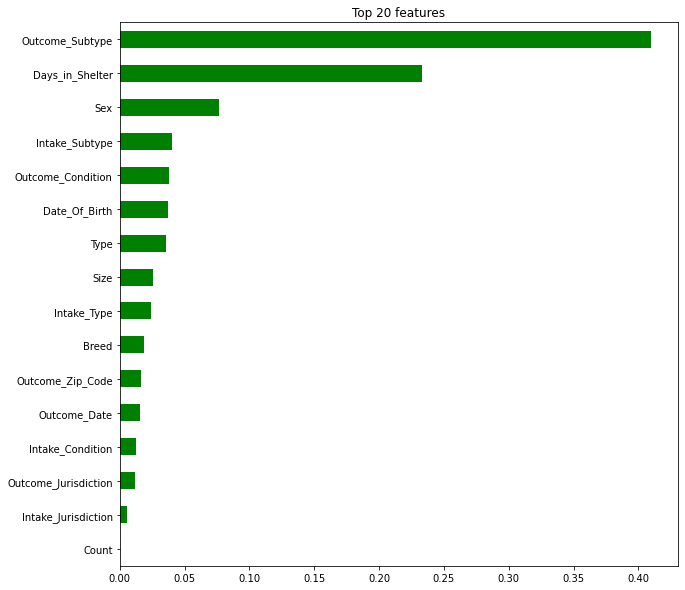

In [ ]:
# getting feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# plot feature importances
import matplotlib.pyplot as plt


n=20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='green');

In [ ]:
# drop-column importance

column = 'Outcome_Subtype'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without Outcome_Subtype: 0.8744407992842231
Validation Accuracy with Outcome_Subtype: 0.923352221890844
Drop-Column Importance for Outcome_Subtype: 0.04891142260662085


In [ ]:
# permutation importance

feature = 'Outcome_Subtype'

# permute
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

X_val[feature].head()
X_val[feature].value_counts()

# Get the permutation importance
score_permuted = pipeline.score(X_val_permuted, y_val)

print(f'Validation Accuracy with {feature}: {score_with}')
print(f'Validation Accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation Importance: {score_with - score_permuted}')

Validation Accuracy with Outcome_Subtype: 0.923352221890844
Validation Accuracy with Outcome_Subtype permuted: 0.7447062332239786
Permutation Importance: 0.17864598866686543


In [ ]:
# Rerun the permutation importance process, 
# but for a different feature

feature = 'Intake_Subtype'

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])
score_permuted = pipeline.score(X_val_permuted, y_val)

print(f'Validation Accuracy with {feature}: {score_with}')
print(f'Validation Accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation Importance: {score_with - score_permuted}')

Validation Accuracy with Intake_Subtype: 0.923352221890844
Validation Accuracy with Intake_Subtype permuted: 0.9151506113927825
Permutation Importance: 0.008201610498061451


In [ ]:
# with eli5 library

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, #What is the model?
    scoring='accuracy', #What scoring parameter do you want to use?
    n_iter=5, #How many of random shuffles? 
    random_state=42 
)

permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()

# Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
)

Weight,Feature
0.1679 ± 0.0095,Outcome_Subtype
0.0514 ± 0.0082,Sex
0.0498 ± 0.0022,Days_in_Shelter
0.0180 ± 0.0028,Type
0.0107 ± 0.0017,Outcome_Condition
0.0081 ± 0.0014,Intake_Subtype
0.0056 ± 0.0012,Intake_Type
0.0009 ± 0.0008,Size
0.0003 ± 0.0008,Intake_Jurisdiction
0.0001 ± 0.0003,Breed


In [ ]:
# using importances for feature selection

minimum_importance = 0 
mask = permuter.feature_importances_ > minimum_importance 
features = X_train.columns[mask]
X_train = X_train[features]

X_val = X_val[features]

print('Shape after removing faetures:', X_train.shape)

Shape after removing faetures: (6533, 11)


In [ ]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8839844915001491


In [ ]:
# xgboost for gradient boosting

from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8100208768267223


In [ ]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000, 
    max_depth=7,       
    learning_rate=0.5, 
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val),]

In [ ]:
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='rmse',
          early_stopping_rounds=50) 

[0]	validation_0-rmse:0.280683	validation_1-rmse:0.380304
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.169846	validation_1-rmse:0.369294
[2]	validation_0-rmse:0.109154	validation_1-rmse:0.381572
[3]	validation_0-rmse:0.072578	validation_1-rmse:0.395567
[4]	validation_0-rmse:0.052352	validation_1-rmse:0.407254
[5]	validation_0-rmse:0.040131	validation_1-rmse:0.412308
[6]	validation_0-rmse:0.033406	validation_1-rmse:0.411179
[7]	validation_0-rmse:0.02692	validation_1-rmse:0.417683
[8]	validation_0-rmse:0.023201	validation_1-rmse:0.414684
[9]	validation_0-rmse:0.020551	validation_1-rmse:0.411756
[10]	validation_0-rmse:0.019249	validation_1-rmse:0.408913
[11]	validation_0-rmse:0.017636	validation_1-rmse:0.406841
[12]	validation_0-rmse:0.016195	validation_1-rmse:0.413974
[13]	validation_0-rmse:0.0154	validation_1-rmse:0.418874
[14]	validation_0-rmse:0.014

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

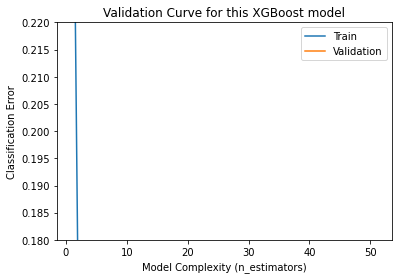

In [ ]:
results = model.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();